###### TODO:

1.  Take MBDNL as the reference to quantify the error ( user relative error )

2.  Check for Cu and Alkaline Earth metals

3.  Find formal charges by beggar's analysis in MBDNL optimised geometry

4.  Consider absolute electronegetiy of each elements present also as a fetaure function ( for the mettalic things )

5.  Polarisibility 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Checking Elements

In [2]:
comp = "RbH"
d3 = pd.read_csv(f'd3/{comp}.csv')
mbd = pd.read_csv(f'mbd/{comp}.csv')


In [3]:
mbd.head()

,cell_length,energy,E-dispersion
0,6.076794,-18.747667,-0.28722
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


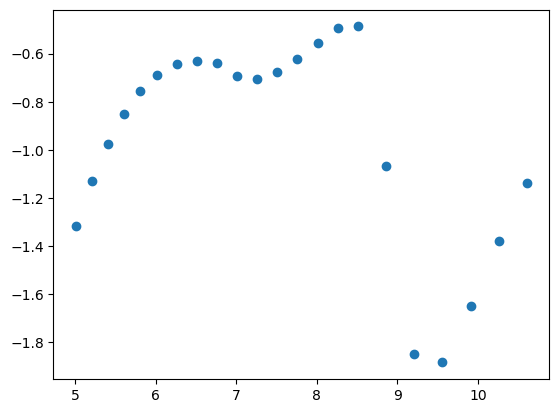

In [4]:
# plt.plot(cuppor['cell_length'], cuppor['energy'], 'o')
plt.scatter(d3['cell_length'], d3['E-dispersion'])

# plt.plot(copper_mbd['cell_length'], copper_mbd['energy'], 'o')
# plt.plot(mbd['cell_length'], mbd['energy'])

plt.show()

### Loading the feature functions from CSV

In [5]:

""" List of molecules strcutrue 
data = {
    "Mol": molecules,  # Molecule
    "Cat_EN": [0.98, 0.93, 0.82, 0.79, 1.90, 1.90, 0.98, 1.90, 1.31, 0.98, 0.93],  # Cation electronegativity
    "Ani_EN": [2.20, 2.20, 2.20, 2.20, 2.20, 1.90, 3.98, 2.66, np.nan, np.nan, np.nan],  # Anion electronegativity
    "Pol_C": [164.1, 162.7, 289.7, 400.9, 46.5, 46.5, 164.1, 46.5, 71.2, 164.1, 162.7],  # Cation polarizability
    "Pol_A": [4.51, 4.51, 4.51, 4.51, 4.51, 46.5, 0.56, 6.35, np.nan, np.nan, np.nan],  # Anion polarizability
    "Rad_C": [152.0, 186.0, 227.0, 343.0, 260.0, 128.0, 152.0, 128.0, 160.0, 152.0, 186.0],  # Cation radius (pm)
    "Rad_A": [53.0, 53.0, 53.0, 53.0, 53.0, np.nan, 147.0, 206.0, np.nan, np.nan, np.nan],  # Anion radius (pm)
    "CN": [6.0, 6.0, 6.0, 6.0, 6.0, np.nan, 6.0, 6.0, 6.0, np.nan, np.nan],  # Coordination number
    "Ion_C": [520.2, 495.8, 418.8, 376.6, 745.5, 745.5, 520.2, 745.5, 737.7, 520.2, 495.8],  # Cation ionization energy (kJ/mol)
    "Ion_A": [1312.0, 1312.0, 1312.0, 1312.0, 1312.0, np.nan, 1681.0, 1007.0, np.nan, np.nan, np.nan],  # Anion ionization energy (kJ/mol)
    "EA_A": [72.8, 72.8, 72.8, 72.8, 72.8, np.nan, 328.0, 295.0, np.nan, np.nan, np.nan],  # Anion electron affinity (kJ/mol)
    "EA_C": [59.6, 52.8, 48.4, 45.5, 119.2, 119.2, 59.6, 119.2, 0.0, 59.6, 52.8],  # Cation electron affinity (kJ/mol)
}

"""

# Create a DataFrame
df = pd.read_csv("molecule_properties_shortest.csv")

# Save to a CSV file
molecules = df['Mol'].values


molecules = molecules[:-5]
molecules


array(['LiH', 'NaH', 'KH', 'RbH', 'CsH', 'LiCl'], dtype=object)

### Trimming the feature data frame

In [6]:
df = df.iloc[:7,0:11]
df

,Mol,Cat_EN,Ani_EN,Pol_C,Pol_A,Rad_C,Rad_A,CN_C,CN_A,Ion_C,Ion_A
0,LiH,0.98,2.20,164.1,4.51,152,53,6,6,5.392,13.590
1,NaH,0.93,2.20,162.7,4.51,186,53,6,6,5.139,13.590
2,KH,0.82,2.20,289.7,4.51,227,53,6,6,4.341,13.590
3,RbH,0.79,2.20,400.9,4.51,343,53,6,6,4.177,13.590
4,CsH,1.90,2.20,46.5,4.51,260,53,6,6,3.849,13.590
5,LiCl,0.98,3.16,164.1,0.56,152,180,6,6,5.392,17.423
6,CuI,1.90,2.66,46.5,6.35,128,206,4,4,7.726,10.451


### Find all the combinations

In [7]:
## Generating all the cominations of the parameters

import itertools
import numpy as np
import pandas as pd

def generate_combinations_df(params_df, param_names):
    results = []

    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    # Convert to float to handle integer to negative power issue
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

    # Generate all subsets of parameters (combinations)
    for r in range(1, len(combined_param_names) + 1):
        for subset_indices in itertools.combinations(range(len(combined_param_names)), r):

            subset_names = [combined_param_names[i] for i in subset_indices]
            subset = combined_params_df[subset_names]

            # Replace NaN values with 0
            subset = subset.fillna(0)

            # Check if both a parameter and its inverse are in the subset
            invalid = False
            for name in subset_names:
                if name.endswith("^(-1)") and name[:-5] in subset_names:
                    invalid = True
                    break
                elif name in param_names and f"{name}^(-1)" in subset_names:
                    invalid = True
                    break

            if invalid:
                continue

            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))

    return results

In [8]:

import os
import pandas as pd

# Define file name to save/load the results
cache_file = "cached_expressions.pkl"

if os.path.exists(cache_file):
    # Load the cached results if they exist
    expressions = pd.read_pickle(cache_file)
    print("Loaded cached expressions.")
else:
    # Perform the costly computation if cache does not exist
    print("Calculating expressions...")
    param_names = list(df.iloc[:7,1:11].columns)
    all_expressions = generate_combinations_df(df.iloc[0:7, 1:11], param_names[:10])
    expressions = pd.DataFrame(all_expressions, columns=['Expression', 'Value'])

    # Save the results to cache
    expressions.to_pickle(cache_file)
    print("Expressions cached.")

# Print the shape of the expressions DataFrame
print(expressions.shape)


Loaded cached expressions.
(59048, 2)


In [9]:
expressions.head()

,Expression,Value
0,Cat_EN,0 0.98 1 0.93 2 0.82 3 0.79 4 1...
1,Ani_EN,0 2.20 1 2.20 2 2.20 3 2.20 4 2...
2,Pol_C,0 164.1 1 162.7 2 289.7 3 400.9 4 ...
3,Pol_A,0 4.51 1 4.51 2 4.51 3 4.51 4 4...
4,Rad_C,0 152 1 186 2 227 3 343 4 260 5...


### Adding the Result of Errors to the combinations 

Cheking Linear Corelations

In [10]:
%store -r res
res

[10.949597164494895,
 10.541726430016613,
 10.418474212336614,
 9.50800562688988,
 9.011645790668272,
 4.711644133098936,
 2.281612873138524]

In [11]:

values_dict = {expr_str: expr_val for expr_str, expr_val in all_expressions}
values = pd.DataFrame(values_dict)
values['res'] = res


NameError: name 'all_expressions' is not defined

In [34]:
values.head()

correlation = values.corr()

correlation.shape

MemoryError: Unable to allocate 26.0 GiB for an array with shape (59049, 59049) and data type float64

In [ ]:
import dask.dataframe as dd

dask_values = dd.from_pandas(values, npartitions=10)
correlation = dask_values.corr().compute()

ImportError: pyarrow>=10.0.1 is required for PyArrow backed StringArray.

In [21]:
results=correlation['res'].abs().sort_values(ascending=False)
print(results.iloc[0:20])
top_vars = results.iloc[1:20].index

res                                                                                  1.000000
Rad_A * CN_A * CN_C^(-1) * Ion_C^(-1) * Ion_A^(-1)                                   0.992224
Rad_A * CN_C * CN_A^(-1) * Ion_C^(-1) * Ion_A^(-1)                                   0.992224
Rad_A * Ion_C^(-1) * Ion_A^(-1)                                                      0.992224
CN_A * Ion_A * Rad_C^(-1) * Rad_A^(-1) * Ion_C^(-1)                                  0.989560
CN_C * Ion_A * Rad_C^(-1) * Rad_A^(-1) * Ion_C^(-1)                                  0.989560
Cat_EN * Rad_A * CN_C * Ion_A * Ani_EN^(-1) * Rad_C^(-1) * CN_A^(-1) * Ion_C^(-1)    0.983971
Cat_EN * Rad_A * CN_A * Ion_A * Ani_EN^(-1) * Rad_C^(-1) * CN_C^(-1) * Ion_C^(-1)    0.983971
Cat_EN * Rad_A * Ion_A * Ani_EN^(-1) * Rad_C^(-1) * Ion_C^(-1)                       0.983971
CN_C * Ion_A * Rad_A^(-1)                                                            0.983485
CN_A * Ion_A * Rad_A^(-1)                                   

### checking non linear Relation ( spearman )

In [ ]:
non_linear_corr = values.corr(method='spearman')


In [ ]:

temp=non_linear_corr['res'].abs().sort_values(ascending=False)
print(temp.iloc[0:30])

res                                                                      1.000000
CN * Ion_C * Ion_A * Rad_A^(-1)                                          1.000000
Ani_EN * Rad_C * Rad_A * Ion_C * CN^(-1)                                 1.000000
Ion_C * Cat_EN^(-1) * Ani_EN^(-1) * Rad_C^(-1) * Rad_A^(-1) * CN^(-1)    1.000000
CN * Ion_A * Ani_EN^(-1) * Rad_C^(-1) * Rad_A^(-1) * Ion_C^(-1)          1.000000
Rad_C * Rad_A * Ion_C * Ion_A                                            1.000000
Rad_C * Rad_A * CN * Ion_C * Ion_A                                       1.000000
Rad_C * Rad_A * Ion_C * CN^(-1)                                          1.000000
Rad_C * Rad_A * Ion_C * Ion_A * Ani_EN^(-1)                              1.000000
Rad_C * Rad_A * CN^(-1) * Ion_A^(-1)                                     1.000000
Rad_A * CN^(-1) * Ion_C^(-1) * Ion_A^(-1)                                1.000000
Rad_C * Rad_A                                                            1.000000
CN * Rad_C^(-1) 

### kendal Corelations

In [127]:
kendall_corr = values.corr(method='kendall')

KeyboardInterrupt: 

In [ ]:
temp = kendall_corr['res'].abs().sort_values(ascending=False)

print(temp.iloc[0:30])

### More to try 
1. Mutual info regression 

2. Maximal Information Coefficient 

3.  Distance Correlation

### Final List of Results

In [22]:
results=correlation['res'].abs().sort_values(ascending=False)
print(results.iloc[0:20])
top_vars = results.iloc[1:20].index

res                                                                                  1.000000
Rad_A * CN_A * CN_C^(-1) * Ion_C^(-1) * Ion_A^(-1)                                   0.992224
Rad_A * CN_C * CN_A^(-1) * Ion_C^(-1) * Ion_A^(-1)                                   0.992224
Rad_A * Ion_C^(-1) * Ion_A^(-1)                                                      0.992224
CN_A * Ion_A * Rad_C^(-1) * Rad_A^(-1) * Ion_C^(-1)                                  0.989560
CN_C * Ion_A * Rad_C^(-1) * Rad_A^(-1) * Ion_C^(-1)                                  0.989560
Cat_EN * Rad_A * CN_C * Ion_A * Ani_EN^(-1) * Rad_C^(-1) * CN_A^(-1) * Ion_C^(-1)    0.983971
Cat_EN * Rad_A * CN_A * Ion_A * Ani_EN^(-1) * Rad_C^(-1) * CN_C^(-1) * Ion_C^(-1)    0.983971
Cat_EN * Rad_A * Ion_A * Ani_EN^(-1) * Rad_C^(-1) * Ion_C^(-1)                       0.983971
CN_C * Ion_A * Rad_A^(-1)                                                            0.983485
CN_A * Ion_A * Rad_A^(-1)                                   

### Cheking the final results

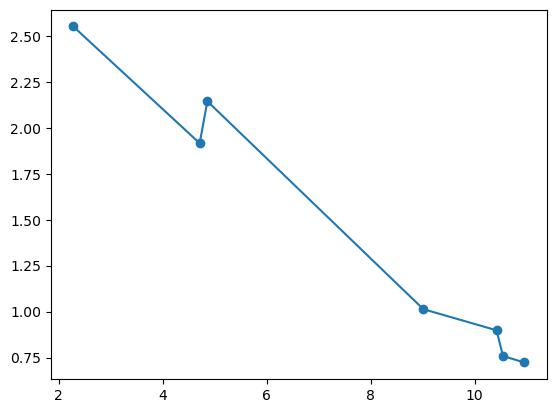

[10.949597164494893,
 10.541726430016613,
 10.418474212336621,
 9.011645790668272,
 4.711644133098936,
 2.281612873138524]

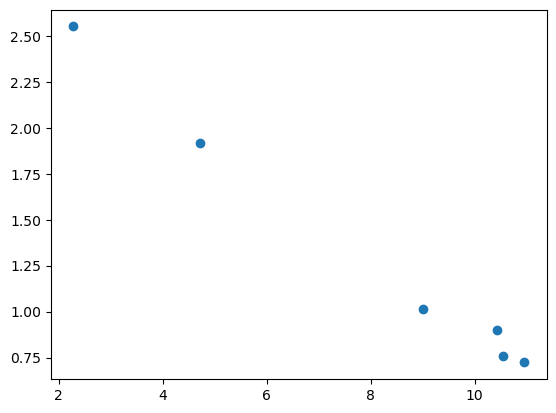

In [48]:

plt.scatter(values['res'],values[top_vars[0]])
plt.plot(values['res'],values[top_vars[0]])
plt.show()

values[top_vars[0]]


# param = df['Cat_EN']*df['Ani_EN']*df['Rad_C']*df['CN']*df['Ion_C']*df['Ion_A']

y = values[top_vars[0]]
x = values['res']


y = list(values[top_vars[0]])[:4]+list(values[top_vars[0]])[5:]
x = list(values['res'])[:4]+list(values['res'])[5:]

plt.scatter(x,y)
x


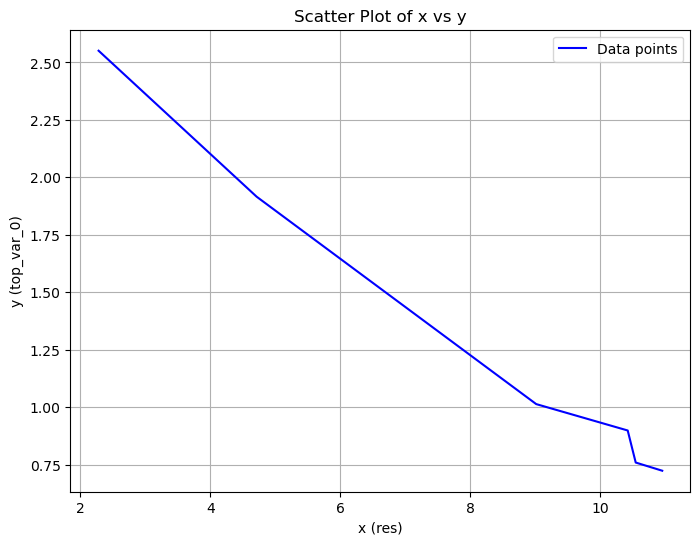

(-4.534769815006395, 60.46271505797129)

In [50]:
from sklearn.metrics import mean_squared_error, r2_score



# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(x, y, color='blue', label='Data points')
plt.title('Scatter Plot of x vs y')
plt.xlabel('x (res)')
plt.ylabel('y (top_var_0)')
plt.grid()
plt.legend()
plt.show()

# Calculate R^2 and MSD
r_squared = r2_score(x, y)
msd = mean_squared_error(x, y)

r_squared, msd

In [112]:
import pickle

# Save the variable to a pickle file
with open('corel.pkl', 'wb') as f:
    pickle.dump(results, f)

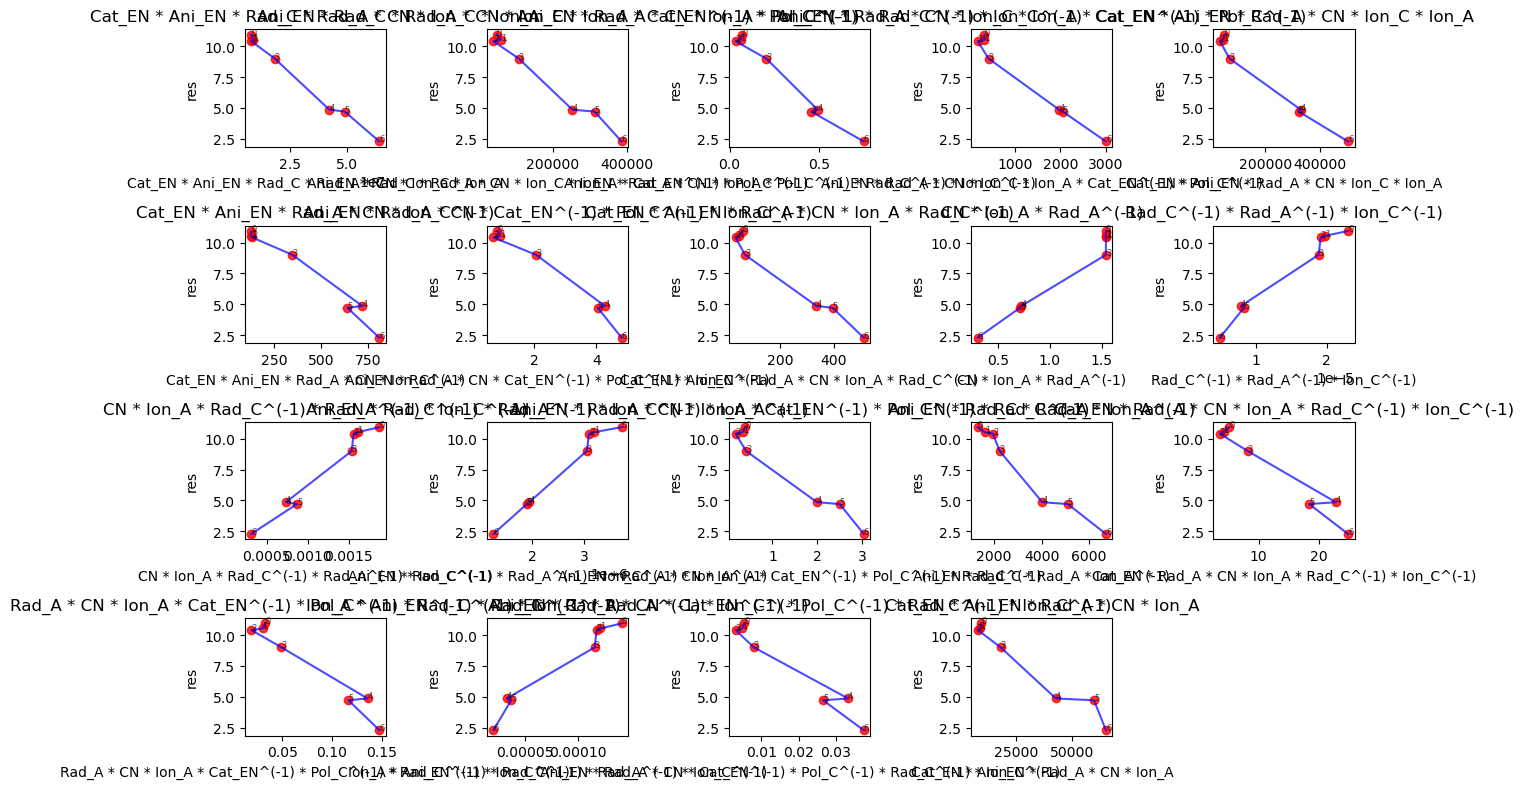

In [113]:
# Plot each variable against `res`
plt.figure(figsize=(12, 8))

for i, var in enumerate(top_vars, 1):
    plt.subplot(4, 5, i)  # 4 rows, 5 columns for subplots
    
    # Plot the line
    plt.plot(values[var], values['res'], linestyle='-', color='blue', alpha=0.7)
    
    # Scatter plot with markers
    plt.scatter(values[var], values['res'], marker='o', color='red', alpha=0.8)
    
    # Annotate each point with its index
    for idx in range(len(values)):
        plt.text(values[var].iloc[idx], values['res'].iloc[idx], str(idx), fontsize=6, color='black', alpha=0.7)
    
    # Titles and labels
    plt.title(var)
    plt.xlabel(var)
    plt.ylabel('res')

plt.tight_layout()
plt.show()


### Feature functions to be used

1. Electronegetivities of each atom involded

2. sum of electronegetivities 

3. Difference of electronegetivities

4. polarisibility

6. Redox potentials 

7. Atomic raiis , sum of atomic raii

8. Formal Charges ( dont know how to take that )

9. Also should have test data 

10. coordination number

### TODO:
1. Check the Y values more properly and accurately 

2. Add more compunds 

3. Try for more feature fucntions 
